# Notebook to demonstrate the use of new functionality in utils.py

In [1]:
import numpy as np
import pandas as pd

from importlib import reload
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display

from matplotlib import rcParams 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
from wombats import utils
from wombats import metrics
from wombats import models

# if changes to the files run this to reload the moduls
utils = reload(utils)
metrics = reload(metrics)
models = reload(models)

In [3]:
data_file = Path('/home/alexgonzalez/Documents/data/steinmetz/steinmetz_all.npy')
if not data_file.exists():
    data = utils.load_steinmentz()
    np.save(data_file, data)
else:
    data = np.load(data_file, allow_pickle=True)

## selection one session to demonstrate

In [4]:
session = 1 
samp_rate = 0.01  # in secs 10ms per bin
session_data = data[session]
n_neurons, n_trials, n_trial_samps = session_data['spks'].shape

print(f'Number of neurons {n_neurons}')
print(f'Number of trials {n_trials}')


Number of neurons 1070
Number of trials 251


### function to demonstrate: spikes_to_fr

In [5]:
?utils.spikes_to_fr

Signature:
utils.spikes_to_fr(
    spk_data,
    samp_rate=0.01,
    smoothing_window=0.05,
    downsampling_factor=1,
    exclude_pre=None,
    exclude_post=None,
    axis=2,
)
Docstring:
Args:
    spk_data: np.ndarray n_neurons x n_trials x n_trial_samps.
        operations performed along time (axis=2), otherwise specify axis.
    samp_rate: seconds per time bin [secs/bin]
    smoothing_window: float [secs], smoothing window in seconds
    downsampling_factor: int or 'all' factor to downsample signal, if 'all', a single estimate per neuron / trial         is returned and no filtering is performed. if int, it needs to be divisible by n_trial_samps
    exclude_pre: float [secs], seconds to ignore at the beginning of each trial
    exclude_post: float [secs], seconds to ignore at the end of each trial
    axis: int [au], dimension on which to operate.

    Note that exclusion of data for each trial is only for the output. Smoothing operations will still use these
    time windows to co

## 1. Recreate previous behavior, that is, average the trial samples excluding the first 50 samps.


In [6]:
out = utils.spikes_to_fr(session_data['spks'], downsampling_factor='all', exclude_pre=50*samp_rate)

In [7]:
out.shape

(1070, 251)

Note that the above has the correct dimensions, it collapsed the n_trial_samps dimensions as desired. Did it perform it correctly?

In [8]:
np.allclose(out, session_data['spks'][:,:,50:].sum(axis=2)/2.0)

True

## 2. Let's downsample by 25, which should result in 10 samples per trial

In [9]:
out = utils.spikes_to_fr(session_data['spks'], downsampling_factor=25)

The requested downsampling requires a larger filter. Increase the smoothing.
Min smoothing_window = 0.083 secs


ValueError: 

This results in an error because we need to increase the smoothing to effectively downsample by such a large factor.

In [17]:
# increase smoothing window to 100ms
df = 25
sw = 0.1
out = utils.spikes_to_fr(session_data['spks'], downsampling_factor=df, smoothing_window=sw)

In [18]:
out.shape

(1070, 251, 10)

The shape looks correct! Now lets make sure the values make sense.

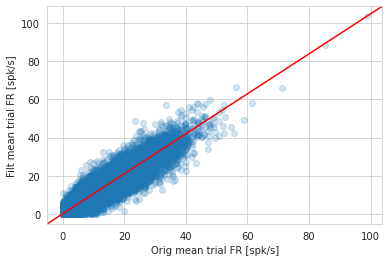

In [19]:
f,ax = plt.subplots()
ax.scatter(session_data['spks'][:,:,:].sum(axis=2)/2.5, out.mean(axis=2), alpha=0.2)
ax.set_xlabel('Orig mean trial FR [spk/s]')
ax.set_ylabel('Filt mean trial FR [spk/s]')
ax.plot([0,1],[0,1], color='r', transform=ax.transAxes)

That's pretty good! now let's examine more carefully within a couple of the appropriate bins to be sure.

In [20]:
@widgets.interact(neuron=(0,n_neurons-1,1))
def tc_comp(neuron):
    f,ax = plt.subplots()
    ax.plot(np.linspace(-.5,2,250), session_data['spks'][neuron,:,:].sum(axis=0)/2.5)
    ax.plot(np.linspace(-.5,2,10),out[neuron].mean(axis=0),linewidth=3)
    ax.set_xlabel('time [secs]')
    ax.set_ylabel('firing rate [spk/s]')



interactive(children=(IntSlider(value=534, description='neuron', max=1069), Output()), _dom_classes=('widget-i…

as it can be seen the function did a good job!

### 3. Downsample and exclude samples

In [22]:
# increase smoothing window to 100ms
df = 10
sw = 0.1
exclude_pre = 50*samp_rate
out = utils.spikes_to_fr(session_data['spks'], downsampling_factor=df, smoothing_window=sw, exclude_pre=exclude_pre)

In [24]:
out.shape

(1070, 251, 20)

In [26]:
@widgets.interact(neuron=(0,n_neurons-1,1))
def tc_comp(neuron):
    f,ax = plt.subplots()
    ax.plot(np.linspace(0,2,200), session_data['spks'][neuron,:,50:].sum(axis=0)/2)
    ax.plot(np.linspace(0,2,20),out[neuron].mean(axis=0),linewidth=3)
    ax.set_xlabel('time [secs]')
    ax.set_ylabel('firing rate [spk/s]')

interactive(children=(IntSlider(value=534, description='neuron', max=1069), Output()), _dom_classes=('widget-i…